In [2]:
import pandas as pd
import numpy as np
import sqlite3
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import seaborn as sns
from pathlib import Path
import warnings
import os

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False

print("✓ 라이브러리 로드 완료")

✓ 라이브러리 로드 완료


In [3]:
rate_path = 'C:\\Users\\jay15\\Desktop\\DB_DATA\\시장금리(일별)_250109.csv'
stock_path = 'C:\\Users\\jay15\\Desktop\\DB_DATA\\국내주가지수(일별)_250109.csv'
vkospi_path = 'C:\\Users\\jay15\\Desktop\\DB_DATA\\VKOSPI(일별)_251231.csv'
db_path = 'C:\\Users\\jay15\\Desktop\\DB_DATA\\repo_trades_2025.db'

# ========== 분석 기간 설정 ==========
START_DATE = "20200101"  # 시작일 (YYYYMMDD)
END_DATE = "20251231"    # 종료일 (YYYYMMDD)

# ========== 기준금리 선택 ==========
BENCHMARK_RATE = 'CD91'  # 'CD91' 또는 'KOFR'

# ========== 출력 폴더 ==========
OUTPUT_DIR = './output'
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(f"✓ 설정 완료")
print(f"  - 분석 기간: {START_DATE} ~ {END_DATE}")
print(f"  - 기준금리: {BENCHMARK_RATE}")
print(f"  - 출력 폴더: {OUTPUT_DIR}")

✓ 설정 완료
  - 분석 기간: 20200101 ~ 20251231
  - 기준금리: CD91
  - 출력 폴더: ./output


In [4]:
# 1) 시장금리
df_rate = pd.read_csv(rate_path, encoding='utf-8')
df_rate['date'] = pd.to_datetime(df_rate['DATE'])

# 컬럼명 정리
df_rate = df_rate.rename(columns={
    'CD(91일)': 'CD91',
    'KOFR(공시RFR)': 'KOFR',
    '  콜금리(1일, 전체거래)': 'CALL',
    '콜금리(1일, 전체거래)': 'CALL',
    'CP(91일)': 'CP91',
    '국고채(3년)': 'KTB3Y',
    '국고채(10년)': 'KTB10Y',
    '국고채(2년)': 'KTB2Y',
    '회사채(3년, AA-)': 'CORP_AA'
})

print("=== 시장금리 데이터 ===")
print(f"Shape: {df_rate.shape}")
print(f"기간: {df_rate['date'].min()} ~ {df_rate['date'].max()}")
print(df_rate.head())

# 2) 주가지수
df_stock = pd.read_csv(stock_path, encoding='utf-8')
df_stock['date'] = pd.to_datetime(df_stock['DATE'])
df_stock['KOSPI'] = pd.to_numeric(df_stock['KOSPI'].astype(str).str.replace(',', ''), errors='coerce')
df_stock['KOSDAQ'] = pd.to_numeric(df_stock['KOSDAQ'].astype(str).str.replace(',', ''), errors='coerce')

print("\n=== 주가지수 데이터 ===")
print(f"Shape: {df_stock.shape}")
print(df_stock.head())

# 3) VKOSPI
df_vkospi = pd.read_csv(vkospi_path, encoding='cp949')
df_vkospi['date'] = pd.to_datetime(df_vkospi['DATE'])
df_vkospi = df_vkospi.rename(columns={'종가': 'VKOSPI'})

print("\n=== VKOSPI 데이터 ===")
print(f"Shape: {df_vkospi.shape}")
print(df_vkospi.head())


=== 시장금리 데이터 ===
Shape: (6199, 29)
기간: 2001-01-02 00:00:00 ~ 2026-01-09 00:00:00
         DATE  CALL    콜금리(1일, 중개회사거래)    콜금리(1일, 은행증권금융차입)  KOFR  \
0  2001-01-02  5.28               5.26                  NaN   NaN   
1  2001-01-03  5.28               5.26                  NaN   NaN   
2  2001-01-04  5.30               5.28                  NaN   NaN   
3  2001-01-05  5.34               5.31                  NaN   NaN   
4  2001-01-08  5.32               5.30                  NaN   NaN   

   KORIBOR(3개월)  KORIBOR(6개월)  KORIBOR(12개월)  CD91  CP91  ...  통안증권(91일)  \
0           NaN           NaN            NaN  6.88  7.26  ...        NaN   
1           NaN           NaN            NaN  6.87  7.26  ...        NaN   
2           NaN           NaN            NaN  6.77  7.24  ...        NaN   
3           NaN           NaN            NaN  6.68  7.18  ...        NaN   
4           NaN           NaN            NaN  6.66  7.11  ...        NaN   

   통안증권(1년)  통안증권(2년)  산금채(1년)  CORP_AA  회사채(3년

In [ ]:
#%%============================================================================
# [Cell 4] 시장 데이터 병합 및 파생변수 생성
#==============================================================================

df_market = df_rate.merge(df_stock[['date', 'KOSPI', 'KOSDAQ']], on='date', how='outer')
df_market = df_market.merge(df_vkospi[['date', 'VKOSPI']], on='date', how='outer')
df_market = df_market.sort_values('date').reset_index(drop=True)

# 파생변수 계산
# 1) 신용스프레드: 회사채(AA-) - 국고채(3년)
if 'CORP_AA' in df_market.columns and 'KTB3Y' in df_market.columns:
    df_market['CreditSpread'] = df_market['CORP_AA'] - df_market['KTB3Y']

# 2) 자금시장 스트레스: 콜금리 - CD(91일)
if 'CALL' in df_market.columns and 'CD91' in df_market.columns:
    df_market['FundingStress'] = df_market['CALL'] - df_market['CD91']

# 3) 수익률곡선 기울기: 국고채(10년) - 국고채(2년)
if 'KTB10Y' in df_market.columns and 'KTB2Y' in df_market.columns:
    df_market['YieldSlope'] = df_market['KTB10Y'] - df_market['KTB2Y']

# 4) KOSPI 수익률
if 'KOSPI' in df_market.columns:
    df_market['KOSPI_ret'] = df_market['KOSPI'].pct_change() * 100

print("=== 병합된 시장 데이터 ===")
print(f"Shape: {df_market.shape}")
print(f"컬럼: {df_market.columns.tolist()}")
print(f"\n파생변수 확인:")
print(df_market[['date', 'CD91', 'CreditSpread', 'FundingStress', 'VKOSPI', 'YieldSlope']].dropna().tail())



=== 병합된 시장 데이터 ===
Shape: (6530, 36)
컬럼: ['DATE', 'CALL', '  콜금리(1일, 중개회사거래)', '  콜금리(1일, 은행증권금융차입)', 'KOFR', 'KORIBOR(3개월)', 'KORIBOR(6개월)', 'KORIBOR(12개월)', 'CD91', 'CP91', '국민주택채권1종(5년)', '국고채(1년)', 'KTB2Y', 'KTB3Y', '국고채(5년)', 'KTB10Y', '국고채(20년)', '국고채(30년)', '국고채(50년)', '통안증권(91일)', '통안증권(1년)', '통안증권(2년)', '산금채(1년)', 'CORP_AA', '회사채(3년, BBB-)', '회사채(3년, AA-, 민평)', 'MMF(7일)', 'CMA(수시형)', 'date', 'KOSPI', 'KOSDAQ', 'VKOSPI', 'CreditSpread', 'FundingStress', 'YieldSlope', 'KOSPI_ret']

파생변수 확인:
           date  CD91  CreditSpread  FundingStress  VKOSPI  YieldSlope
6516 2025-12-23  2.85         0.537         -0.303   26.11       0.577
6517 2025-12-24  2.86         0.536         -0.317   25.99       0.569
6519 2025-12-26  2.87         0.531         -0.317   26.20       0.579
6520 2025-12-29  2.87         0.531         -0.348   27.48       0.576
6521 2025-12-30  2.87         0.524         -0.330   28.85       0.589


In [6]:
conn = sqlite3.connect(db_path)

# 테이블 목록 확인
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(f"테이블 목록: {tables['name'].tolist()}")

# 전체 데이터 로딩 (기간 필터는 나중에)
df_repo_raw = pd.read_sql("SELECT * FROM repo_trades", conn)
conn.close()

print(f"\n=== RP 거래 데이터 ===")
print(f"Shape: {df_repo_raw.shape}")
print(f"Columns: {df_repo_raw.columns.tolist()}")
print(f"\n첫 5행:")
print(df_repo_raw.head())

테이블 목록: ['repo_trades', 'collection_status']

=== RP 거래 데이터 ===
Shape: (1605808, 22)
Columns: ['basDt', 'rpSqno', 'rpBuyAplCurCd', 'rpBuyAplCurCdNm', 'rdptTermCcd', 'rdptTermCcdNm', 'rpRmngExprDcd', 'rpRmngExprDcdNm', 'rpInrt', 'slngShtrFinBzcDcd', 'slngShtrFinBzcDcdNm', 'buynShtrFinBzcDcd', 'buynShtrFinBzcDcdNm', 'rpOpngDt', 'rpBuyAmt', 'rpMrgamRto', 'scrsItmsKcd', 'scrsItmsKcdNm', 'isinCd', 'isinCdNm', 'buyScrtBuyAmt', 'buyScrtEvlAmt']

첫 5행:
      basDt        rpSqno rpBuyAplCurCd rpBuyAplCurCdNm rdptTermCcd  \
0  20250102  202501020001           USD           미국 달러           4   
1  20250102  202501020002           USD           미국 달러           4   
2  20250102  202501020003           USD           미국 달러           5   
3  20250102  202501020004           USD           미국 달러           5   
4  20250102  202501020005           USD           미국 달러           5   

  rdptTermCcdNm rpRmngExprDcd rpRmngExprDcdNm  rpInrt slngShtrFinBzcDcd  ...  \
0     1월이상 3월미만            12            3년이

In [7]:
print(f"=== RP 데이터 기본 정보 ===")
print(f"날짜 범위: {df_repo_raw['basDt'].min()} ~ {df_repo_raw['basDt'].max()}")
print(f"고유 날짜 수: {df_repo_raw['basDt'].nunique()}")
print(f"총 거래 건수: {len(df_repo_raw):,}")

print("\n매도업종 (자금수요자):")
print(df_repo_raw['slngShtrFinBzcDcdNm'].value_counts())

print("\n매수업종 (자금공급자):")
print(df_repo_raw['buynShtrFinBzcDcdNm'].value_counts())

print("\n담보 유형:")
print(df_repo_raw['scrsItmsKcdNm'].value_counts())

print("\n만기 구분:")
if 'rdptTermCcdNm' in df_repo_raw.columns:
    print(df_repo_raw['rdptTermCcdNm'].value_counts())

print("\nRP 금리 통계:")
print(df_repo_raw['rpInrt'].describe())


=== RP 데이터 기본 정보 ===
날짜 범위: 20250102 ~ 20251231
고유 날짜 수: 238
총 거래 건수: 1,605,808

매도업종 (자금수요자):
slngShtrFinBzcDcdNm
집합투자       1112966
증권사         323675
국가·지자체       58113
증권사(신탁)      50474
비거주자         27430
외국은행         18690
여신 금융업        8927
보험            3238
국내은행          2196
연기금·공제          76
기타 금융업          23
Name: count, dtype: int64

매수업종 (자금공급자):
buynShtrFinBzcDcdNm
집합투자       928547
은행(신탁)     270208
증권사(신탁)     98792
증권사         75245
국내은행        61118
비거주자        42013
여신 금융업      40509
보험          36612
연기금·공제      31057
외국은행        10472
기타(신탁)       9135
국가·지자체       1934
기타 금융업        166
Name: count, dtype: int64

담보 유형:
scrsItmsKcdNm
국채        661139
금융채       359502
은행채       280100
특수채       173756
회사채        81546
통안채        27863
주식.ETF     12265
지방채         9637
Name: count, dtype: int64

만기 구분:
rdptTermCcdNm
1영업일           1503788
7일이상 1월미만        40647
3월이상 1년미만        23477
1월이상 3월미만        18194
2영업일이상 7일미만      16181
1년이상              3521
Name: count

In [8]:
# 날짜 변환
df_repo = df_repo_raw.copy()
df_repo['basDt'] = df_repo['basDt'].astype(str)
df_repo['date'] = pd.to_datetime(df_repo['basDt'], format='%Y%m%d')

# 기간 필터
start_dt = pd.to_datetime(START_DATE, format='%Y%m%d')
end_dt = pd.to_datetime(END_DATE, format='%Y%m%d')
df_repo = df_repo[(df_repo['date'] >= start_dt) & (df_repo['date'] <= end_dt)]

# 유효 데이터 필터 (rpBuyAmt로 수정!)
df_repo = df_repo[df_repo['rpInrt'].notna()]
df_repo = df_repo[df_repo['rpBuyAmt'] > 0]

print(f"=== 필터링 후 RP 데이터 ===")
print(f"기간: {df_repo['date'].min().strftime('%Y-%m-%d')} ~ {df_repo['date'].max().strftime('%Y-%m-%d')}")
print(f"거래 건수: {len(df_repo):,}")
print(f"거래 금액: {df_repo['rpBuyAmt'].sum()/1e12:.1f}조원")

=== 필터링 후 RP 데이터 ===
기간: 2025-01-02 ~ 2025-12-31
거래 건수: 1,605,808
거래 금액: 42414.5조원


In [9]:
def classify_collateral(collateral_name):
    """
    담보증권 유형을 분류하는 함수
    scrsItmsKcdNm (담보증권종류명) 기반
    """
    if pd.isna(collateral_name) or collateral_name == '':
        return '기타'
    
    name = str(collateral_name)
    
    # 국고채
    if any(kw in name for kw in ['국고', '국채', '국고채권']):
        return '국고채'
    
    # 통안채
    if any(kw in name for kw in ['통안', '통화안정']):
        return '통안채'
    
    # 특수채 (정책금융기관채)
    if any(kw in name for kw in ['특수채', '지방채', '공사']):
        return '특수채'
    
    # 금융채
    if any(kw in name for kw in ['금융', '은행', '금융채']):
        return '금융채'
    
    # 회사채
    if any(kw in name for kw in ['회사', '일반회사채', '사채']):
        return '회사채'
    
    return '기타'


# 담보유형 컬럼 추가
df_repo['collateral_type'] = df_repo['scrsItmsKcdNm'].apply(classify_collateral)

print("=== 담보유형 분류 결과 ===")
collateral_dist = df_repo.groupby('collateral_type').agg(
    거래건수=('rpBuyAmt', 'count'),
    거래금액_조원=('rpBuyAmt', lambda x: x.sum()/1e12)
).round(2)
print(collateral_dist.sort_values('거래금액_조원', ascending=False))

print("\n=== 원본 담보유형(scrsItmsKcdNm) 분포 ===")
print(df_repo['scrsItmsKcdNm'].value_counts())

=== 담보유형 분류 결과 ===
                   거래건수   거래금액_조원
collateral_type                  
국고채              661139  17901.37
금융채              639602  16509.65
특수채              183393   5139.88
회사채               81546   1359.41
통안채               27863   1194.01
기타                12265    310.18

=== 원본 담보유형(scrsItmsKcdNm) 분포 ===
scrsItmsKcdNm
국채        661139
금융채       359502
은행채       280100
특수채       173756
회사채        81546
통안채        27863
주식.ETF     12265
지방채         9637
Name: count, dtype: int64


In [10]:
#%%============================================================================
# [Cell 9] 스프레드 계산 - RP금리와 시장데이터 병합
#==============================================================================

# 시장데이터에서 필요한 컬럼만 선택
market_cols = ['date', BENCHMARK_RATE, 'CreditSpread', 'FundingStress', 
               'YieldSlope', 'VKOSPI', 'KOSPI_ret']
market_cols = [c for c in market_cols if c in df_market.columns]

df_market_sub = df_market[market_cols].dropna(subset=[BENCHMARK_RATE])

# RP 데이터와 병합
df = df_repo.merge(df_market_sub, on='date', how='inner')

# 스프레드 계산 (bp 단위)
df['spread'] = (df['rpInrt'] - df[BENCHMARK_RATE]) * 100  # bp

print(f"=== 스프레드 계산 완료 ===")
print(f"병합 후 거래건수: {len(df):,}")
print(f"스프레드 통계 (bp):")
print(df['spread'].describe())

# 이상치 확인
print(f"\n스프레드 분포:")
print(f"  < -100bp: {(df['spread'] < -100).sum():,}건")
print(f"  -100 ~ 0bp: {((df['spread'] >= -100) & (df['spread'] < 0)).sum():,}건")
print(f"  0 ~ 100bp: {((df['spread'] >= 0) & (df['spread'] < 100)).sum():,}건")
print(f"  > 100bp: {(df['spread'] >= 100).sum():,}건")

=== 스프레드 계산 완료 ===
병합 후 거래건수: 1,605,808
스프레드 통계 (bp):
count    1.605808e+06
mean     2.710943e+00
std      3.823333e+01
min     -3.260000e+02
25%     -6.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      4.440000e+03
Name: spread, dtype: float64

스프레드 분포:
  < -100bp: 6,421건
  -100 ~ 0bp: 775,965건
  0 ~ 100bp: 786,892건
  > 100bp: 36,530건


In [ ]:
#%%============================================================================
# [Cell 10] Table 1: 담보유형별 기초통계
#==============================================================================


table1 = df.groupby('collateral_type').agg(
    평균스프레드_bp=('spread', 'mean'),
    표준편차_bp=('spread', 'std'),
    중위수_bp=('spread', 'median'),
    평균금리_pct=('rpInrt', 'mean'),
    거래건수=('rpBuyAmt', 'count'),
    거래금액_조원=('rpBuyAmt', lambda x: x.sum()/1e12)
).round(2)

table1 = table1.sort_values('거래금액_조원', ascending=False)

print("=" * 70)
print("📊 Table 1: 담보유형별 기초통계")
print("=" * 70)
print(table1)

📊 Table 1: 담보유형별 기초통계
                 평균스프레드_bp  표준편차_bp  중위수_bp  평균금리_pct    거래건수   거래금액_조원
collateral_type                                                        
국고채                   5.47    55.74    -1.0      2.75  661139  17901.37
금융채                   0.11    13.26     1.0      2.70  639602  16509.65
특수채                  -2.43    15.73    -1.0      2.66  183393   5139.88
회사채                  10.71    19.74     7.0      2.80   81546   1359.41
통안채                   8.49    52.86    -2.0      2.79   27863   1194.01
기타                    0.62    20.73    -2.0      2.72   12265    310.18


In [14]:
#%%============================================================================
# [Cell 11] Table 2: 담보유형 × 매도자(자금수요자) 업종별 스프레드
#==============================================================================

# 가중평균 스프레드 계산
grouped_seller = df.groupby(['collateral_type', 'slngShtrFinBzcDcdNm']).apply(
    lambda x: pd.Series({
        'weighted_spread': np.average(x['spread'], weights=x['rpBuyAmt']) if x['rpBuyAmt'].sum() > 0 else np.nan,
        'volume_trillion': x['rpBuyAmt'].sum() / 1e12
    })
).reset_index()

# 스프레드 피벗
table2_spread = grouped_seller.pivot(
    index='collateral_type',
    columns='slngShtrFinBzcDcdNm',
    values='weighted_spread'
).round(2)

# 거래량 피벗
table2_volume = grouped_seller.pivot(
    index='collateral_type',
    columns='slngShtrFinBzcDcdNm',
    values='volume_trillion'
).round(2)

print("=" * 70)
print("📊 Table 2: 담보유형 × 매도자(자금수요자) 업종별 평균 스프레드 (bp)")
print("=" * 70)
print(table2_spread)

print("\n[참고] 거래금액 (조원):")
print(table2_volume)

📊 Table 2: 담보유형 × 매도자(자금수요자) 업종별 평균 스프레드 (bp)
slngShtrFinBzcDcdNm  국가·지자체   국내은행  기타 금융업    보험    비거주자  여신 금융업  연기금·공제  \
collateral_type                                                            
국고채                   -1.75  -8.70   -2.35 -7.41   48.43   -3.38   -2.22   
금융채                    1.13  -9.51     NaN -1.68  217.00    1.24   -7.21   
기타                      NaN    NaN     NaN  4.00     NaN     NaN     NaN   
통안채                   -4.20 -11.51     NaN   NaN  -19.94    3.81     NaN   
특수채                   -2.98  -6.48     NaN -1.05     NaN    1.11  -13.62   
회사채                    1.96 -31.00     NaN -0.56     NaN   -1.82     NaN   

slngShtrFinBzcDcdNm  외국은행    증권사  증권사(신탁)   집합투자  
collateral_type                                   
국고채                 -5.07  -3.53     2.21  -2.36  
금융채                  1.34  -2.49     0.51  -0.14  
기타                    NaN  -5.05      NaN  58.98  
통안채                 -8.18  -4.47      NaN  -1.12  
특수채                   NaN  -4.01    -2.

In [16]:
#%%============================================================================
# [Cell 12] Table 3: 담보유형 × 매수자(자금공급자) 업종별 스프레드
#==============================================================================

# 가중평균 스프레드 계산
grouped_buyer = df.groupby(['collateral_type', 'buynShtrFinBzcDcdNm']).apply(
    lambda x: pd.Series({
        'weighted_spread': np.average(x['spread'], weights=x['rpBuyAmt']) if x['rpBuyAmt'].sum() > 0 else np.nan,
        'volume_trillion': x['rpBuyAmt'].sum() / 1e12
    })
).reset_index()

# 스프레드 피벗
table3_spread = grouped_buyer.pivot(
    index='collateral_type',
    columns='buynShtrFinBzcDcdNm',
    values='weighted_spread'
).round(2)

# 거래량 피벗
table3_volume = grouped_buyer.pivot(
    index='collateral_type',
    columns='buynShtrFinBzcDcdNm',
    values='volume_trillion'
).round(2)

print("=" * 70)
print("📊 Table 3: 담보유형 × 매수자(자금공급자) 업종별 평균 스프레드 (bp)")
print("=" * 70)
print(table3_spread)

print("\n[참고] 거래금액 (조원):")
print(table3_volume)


📊 Table 3: 담보유형 × 매수자(자금공급자) 업종별 평균 스프레드 (bp)
buynShtrFinBzcDcdNm  국가·지자체  국내은행  기타 금융업  기타(신탁)    보험    비거주자  여신 금융업  \
collateral_type                                                           
국고채                   -6.81 -4.40   -2.34   -5.72 -3.35  134.98   -3.35   
금융채                    3.23 -5.15  -22.50   -3.49 -3.53  217.00   -0.31   
기타                      NaN   NaN     NaN     NaN   NaN     NaN   61.87   
통안채                  -14.13 -4.81  166.00   -6.00 -3.96   57.15   -4.51   
특수채                   -1.59 -2.05  -28.75   -3.46 -3.57     NaN   -7.39   
회사채                    2.22  4.15  -25.97   -3.10  1.71     NaN    2.07   

buynShtrFinBzcDcdNm  연기금·공제   외국은행  은행(신탁)    증권사  증권사(신탁)  집합투자  
collateral_type                                                   
국고채                   -3.11  -4.51   -0.79  -0.67     0.74 -2.70  
금융채                   -3.12    NaN   -1.73   2.80     4.17 -0.61  
기타                      NaN    NaN     NaN  60.61    36.47 -5.01  
통안채               

In [18]:
#%%============================================================================
# [Cell 13] Table 4: 매도자-매수자 거래 흐름 (담보유형별)
#==============================================================================

print("=" * 70)
print("📊 Table 4: 담보유형별 매도자-매수자 거래금액 (조원)")
print("=" * 70)

table4_dict = {}

for coll_type in df['collateral_type'].unique():
    df_sub = df[df['collateral_type'] == coll_type]
    
    pivot = df_sub.groupby(['slngShtrFinBzcDcdNm', 'buynShtrFinBzcDcdNm'])['rpBuyAmt'].sum().unstack()
    pivot = (pivot / 1e12).round(2)  # 조원 단위
    
    table4_dict[coll_type] = pivot
    print(f"\n[{coll_type}]")
    print(pivot)

# 전체 통합
print(f"\n[전체]")
pivot_total = df.groupby(['slngShtrFinBzcDcdNm', 'buynShtrFinBzcDcdNm'])['rpBuyAmt'].sum().unstack()
pivot_total = (pivot_total / 1e12).round(2)
print(pivot_total)

📊 Table 4: 담보유형별 매도자-매수자 거래금액 (조원)

[국고채]
buynShtrFinBzcDcdNm  국가·지자체     국내은행  기타 금융업  기타(신탁)      보험  비거주자  여신 금융업  \
slngShtrFinBzcDcdNm                                                          
국가·지자체                  NaN    85.45     NaN     NaN    1.92   NaN    0.48   
국내은행                    NaN    10.13     NaN     NaN     NaN  0.00   14.47   
기타 금융업                  NaN      NaN     NaN     NaN     NaN   NaN     NaN   
보험                      NaN     8.38     NaN     NaN    0.02   NaN   14.94   
비거주자                    NaN     1.54     NaN     NaN     NaN  1.58     NaN   
여신 금융업                  NaN    10.35     NaN     NaN    0.13   NaN    0.42   
연기금·공제                  NaN     0.22     NaN     NaN     NaN   NaN     NaN   
외국은행                   1.05    26.98     NaN     NaN     NaN  0.78     NaN   
증권사                    1.77  1780.90    0.01  132.34   86.82  0.00  132.54   
증권사(신탁)                0.05   251.08     NaN    0.17    1.81   NaN    4.27   
집합투자                  

In [19]:
#%%============================================================================
# [Cell 14] Table 5: 시장변수 기술통계
#==============================================================================

# 분석 기간 필터
df_market_period = df_market[
    (df_market['date'] >= start_dt) & 
    (df_market['date'] <= end_dt)
].copy()

# 기술통계 대상 변수
vars_to_describe = ['CD91', 'KOFR', 'CALL', 'CreditSpread', 
                    'FundingStress', 'YieldSlope', 'VKOSPI', 'KOSPI_ret']
vars_available = [v for v in vars_to_describe if v in df_market_period.columns]

table5 = df_market_period[vars_available].describe().T
table5['count'] = table5['count'].astype(int)
table5 = table5.round(4)

print("=" * 70)
print("📊 Table 5: 시장변수 기술통계")
print("=" * 70)
print(table5)


📊 Table 5: 시장변수 기술통계
               count     mean     std      min      25%      50%      75%  \
CD91            1479   2.3640  1.2180   0.6300   1.0900   2.5900   3.5800   
KOFR            1008   2.8630  0.7799   0.8240   2.5130   3.0955   3.5172   
CALL            1479   2.1522  1.2278   0.4000   0.7500   2.5150   3.4355   
CreditSpread    1479   0.7850  0.3161   0.3920   0.5655   0.7050   0.9475   
FundingStress   1479  -0.2118  0.1895  -0.9930  -0.2915  -0.1900  -0.0875   
YieldSlope      1186   0.2781  0.3373  -0.3270   0.0223   0.1400   0.5060   
VKOSPI          1473  20.8931  6.5711  11.7300  16.9300  19.4100  23.2800   
KOSPI_ret       1566   0.0494  1.2500  -8.7677  -0.6007   0.0271   0.7363   

                   max  
CD91            4.0300  
KOFR            4.0190  
CALL            3.9060  
CreditSpread    1.7720  
FundingStress   0.2970  
YieldSlope      1.2750  
VKOSPI         69.2400  
KOSPI_ret       8.6012  


In [21]:
#%%============================================================================
# [Cell 15] 일별 담보유형별 스프레드 시계열 생성
#==============================================================================

# 일별 담보유형별 가중평균 스프레드
daily_spread = df.groupby(['date', 'collateral_type']).apply(
    lambda x: pd.Series({
        'spread': np.average(x['spread'], weights=x['rpBuyAmt']) if x['rpBuyAmt'].sum() > 0 else np.nan,
        'rate': np.average(x['rpInrt'], weights=x['rpBuyAmt']) if x['rpBuyAmt'].sum() > 0 else np.nan,
        'volume': x['rpBuyAmt'].sum(),
        'count': len(x)
    })
).reset_index()

# Wide format 변환
spread_wide = daily_spread.pivot(
    index='date',
    columns='collateral_type',
    values='spread'
)

print(f"=== 일별 스프레드 시계열 ===")
print(f"일자 수: {len(spread_wide)}")
print(f"담보유형: {spread_wide.columns.tolist()}")
print(spread_wide.tail())

=== 일별 스프레드 시계열 ===
일자 수: 238
담보유형: ['국고채', '금융채', '기타', '통안채', '특수채', '회사채']
collateral_type        국고채        금융채         기타        통안채        특수채  \
date                                                                     
2025-12-24      -29.702528 -26.574359 -28.997416 -31.250485 -29.791750   
2025-12-26      -29.659663 -26.617929 -28.436037 -31.550479 -29.801177   
2025-12-29      -29.926644 -26.842252 -27.888558 -33.737366 -29.716188   
2025-12-30      -29.453828 -26.094184 -31.105847 -30.623428 -29.092775   
2025-12-31      -12.936092  -5.092628        NaN -12.496353 -13.528092   

collateral_type        회사채  
date                        
2025-12-24      -14.450149  
2025-12-26      -15.128723  
2025-12-29      -15.269306  
2025-12-30      -13.665486  
2025-12-31       18.527058  


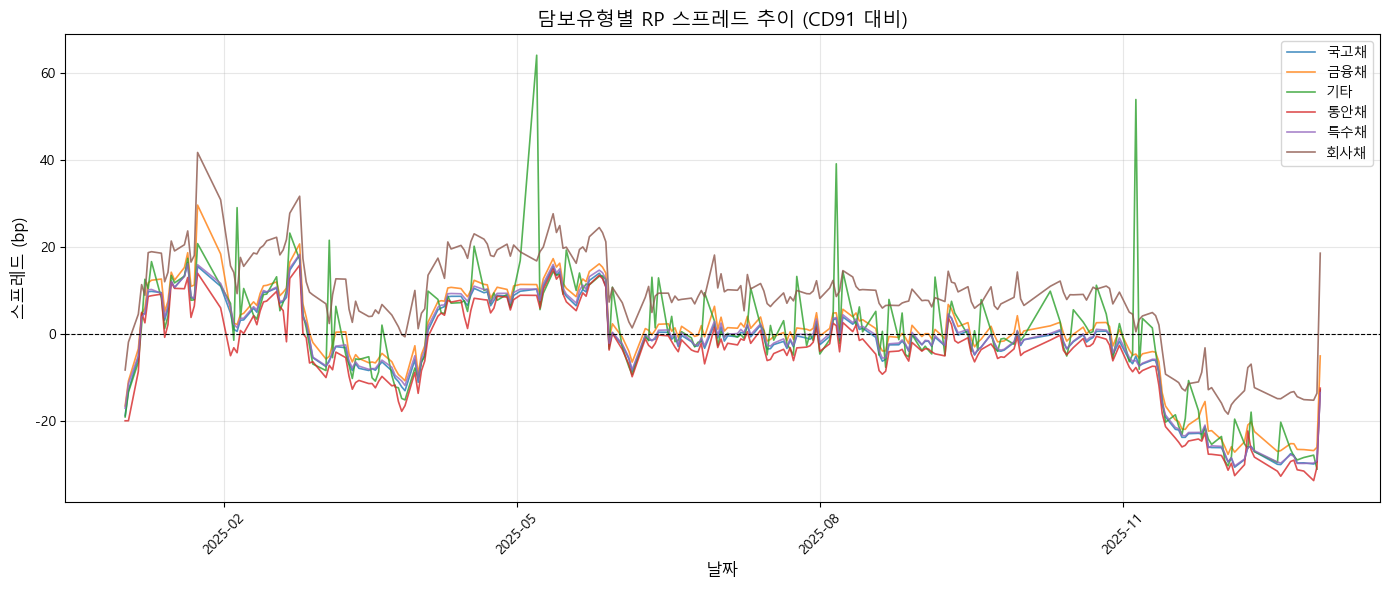

In [22]:
#%%============================================================================
# [Cell 16] Figure 1: 담보유형별 스프레드 시계열
#==============================================================================

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

for i, col in enumerate(spread_wide.columns):
    ax.plot(spread_wide.index, spread_wide[col], 
            label=col, linewidth=1.2, alpha=0.8, color=colors[i % len(colors)])

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('스프레드 (bp)', fontsize=12)
ax.set_title(f'담보유형별 RP 스프레드 추이 ({BENCHMARK_RATE} 대비)', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# x축 날짜 포맷
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

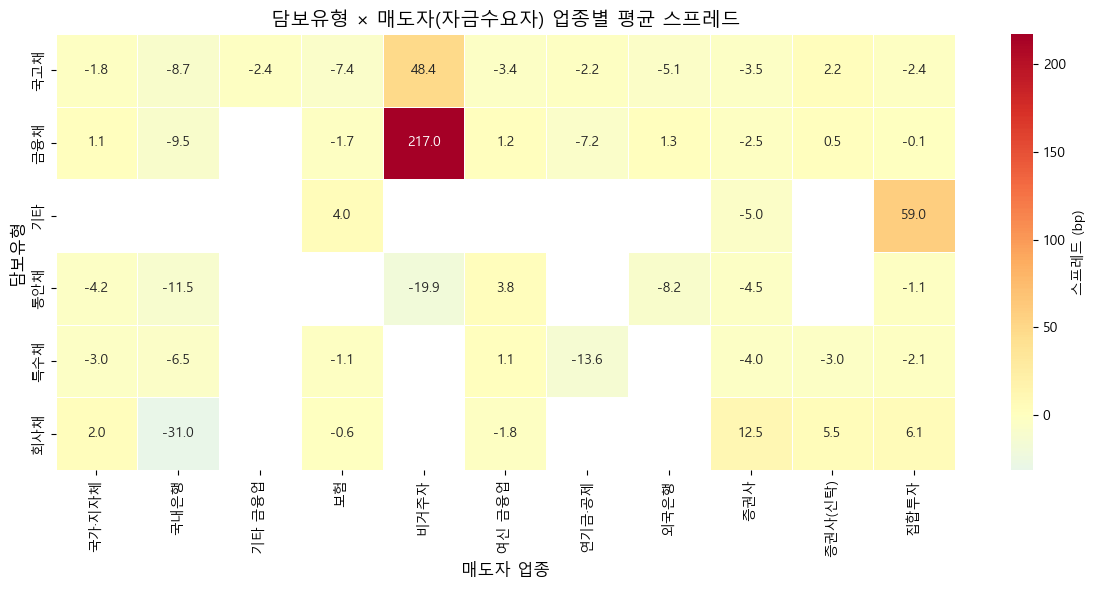

In [23]:
#%%============================================================================
# [Cell 17] Figure 2: 담보유형 × 매도자 업종 히트맵
#==============================================================================

fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(table2_spread, annot=True, fmt='.1f', cmap='RdYlBu_r', 
            center=0, ax=ax, cbar_kws={'label': '스프레드 (bp)'},
            linewidths=0.5)

ax.set_title('담보유형 × 매도자(자금수요자) 업종별 평균 스프레드', fontsize=14)
ax.set_xlabel('매도자 업종', fontsize=12)
ax.set_ylabel('담보유형', fontsize=12)

plt.tight_layout()
plt.show()

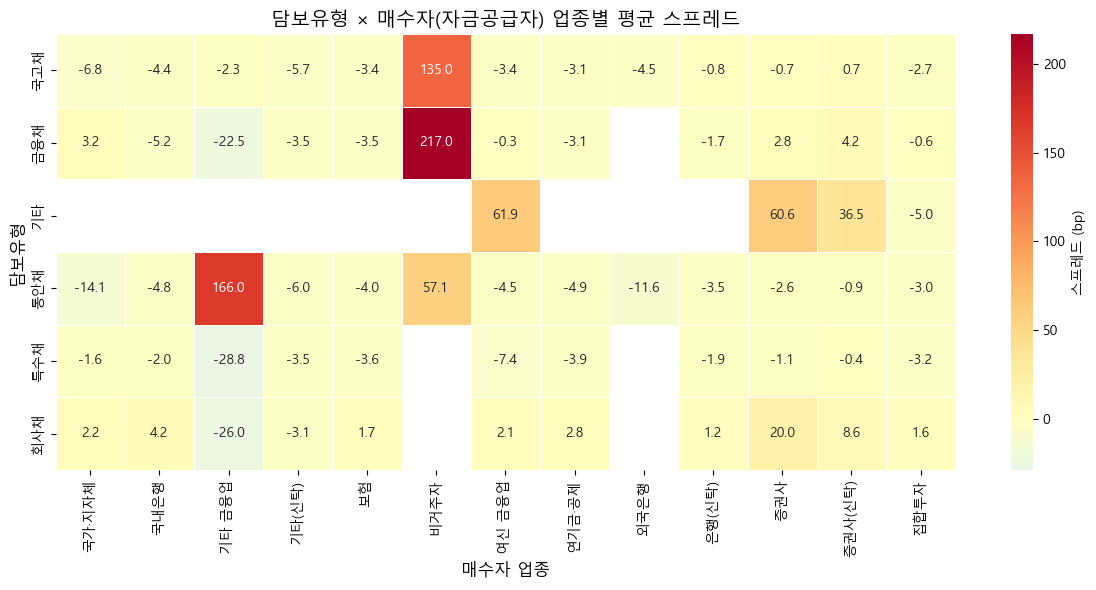

In [24]:
#%%============================================================================
# [Cell 18] Figure 3: 담보유형 × 매수자 업종 히트맵
#==============================================================================

fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(table3_spread, annot=True, fmt='.1f', cmap='RdYlBu_r', 
            center=0, ax=ax, cbar_kws={'label': '스프레드 (bp)'},
            linewidths=0.5)

ax.set_title('담보유형 × 매수자(자금공급자) 업종별 평균 스프레드', fontsize=14)
ax.set_xlabel('매수자 업종', fontsize=12)
ax.set_ylabel('담보유형', fontsize=12)

plt.tight_layout()
plt.show()

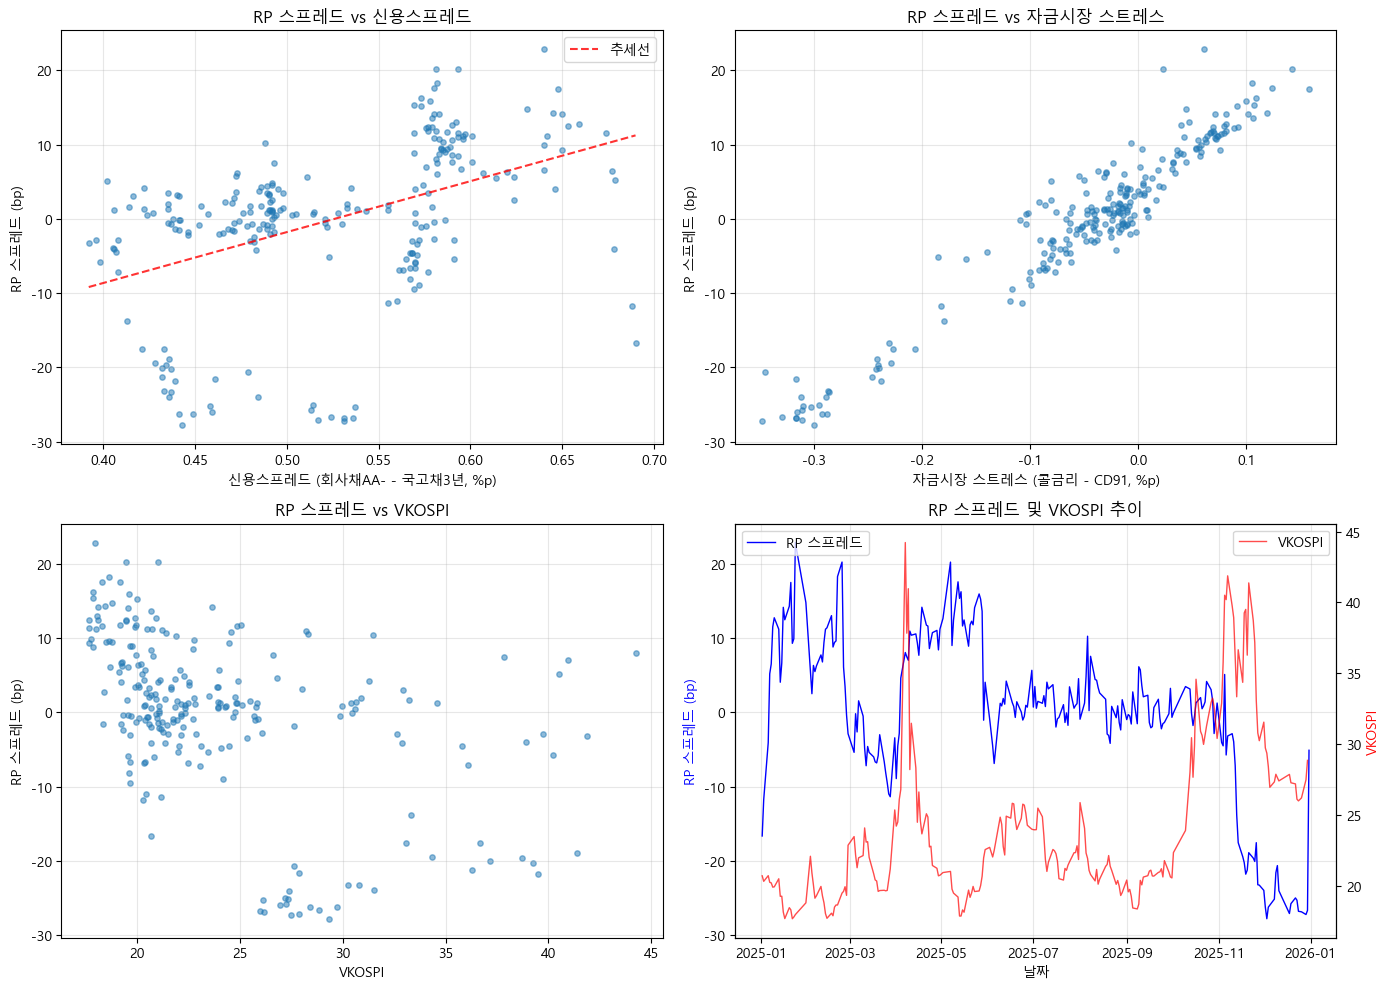

In [25]:
#%%============================================================================
# [Cell 19] Figure 4: 스프레드 vs 시장 스트레스 지표
#==============================================================================

# 일별 평균 스프레드
avg_spread = daily_spread.groupby('date')['spread'].mean().reset_index()
avg_spread = avg_spread.merge(
    df_market[['date', 'CreditSpread', 'FundingStress', 'VKOSPI']], 
    on='date', how='inner'
)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (1) Spread vs CreditSpread
ax = axes[0, 0]
ax.scatter(avg_spread['CreditSpread'], avg_spread['spread'], alpha=0.5, s=15)
ax.set_xlabel('신용스프레드 (회사채AA- - 국고채3년, %p)')
ax.set_ylabel('RP 스프레드 (bp)')
ax.set_title('RP 스프레드 vs 신용스프레드')
ax.grid(True, alpha=0.3)

# 추세선
z = np.polyfit(avg_spread['CreditSpread'].dropna(), 
               avg_spread.loc[avg_spread['CreditSpread'].notna(), 'spread'], 1)
p = np.poly1d(z)
x_line = np.linspace(avg_spread['CreditSpread'].min(), avg_spread['CreditSpread'].max(), 100)
ax.plot(x_line, p(x_line), "r--", alpha=0.8, label=f'추세선')
ax.legend()

# (2) Spread vs FundingStress
ax = axes[0, 1]
ax.scatter(avg_spread['FundingStress'], avg_spread['spread'], alpha=0.5, s=15)
ax.set_xlabel('자금시장 스트레스 (콜금리 - CD91, %p)')
ax.set_ylabel('RP 스프레드 (bp)')
ax.set_title('RP 스프레드 vs 자금시장 스트레스')
ax.grid(True, alpha=0.3)

# (3) Spread vs VKOSPI
ax = axes[1, 0]
ax.scatter(avg_spread['VKOSPI'], avg_spread['spread'], alpha=0.5, s=15)
ax.set_xlabel('VKOSPI')
ax.set_ylabel('RP 스프레드 (bp)')
ax.set_title('RP 스프레드 vs VKOSPI')
ax.grid(True, alpha=0.3)

# (4) 시계열 비교
ax = axes[1, 1]
ax2 = ax.twinx()
ax.plot(avg_spread['date'], avg_spread['spread'], 'b-', label='RP 스프레드', linewidth=1)
ax2.plot(avg_spread['date'], avg_spread['VKOSPI'], 'r-', label='VKOSPI', linewidth=1, alpha=0.7)
ax.set_xlabel('날짜')
ax.set_ylabel('RP 스프레드 (bp)', color='b')
ax2.set_ylabel('VKOSPI', color='r')
ax.set_title('RP 스프레드 및 VKOSPI 추이')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
#%%============================================================================
# [Cell 20] Gorton 스타일 회귀분석 - 데이터 준비
#==============================================================================

def prepare_regression_data(spread_wide, df_market, collateral_type, n_lags=4):
    """
    회귀분석용 데이터 준비
    - Percentage change 계산
    - 시차 변수 생성
    """
    if collateral_type not in spread_wide.columns:
        print(f"⚠ {collateral_type} 데이터 없음")
        return None
    
    # 스프레드 시계열
    df_reg = spread_wide[[collateral_type]].copy()
    df_reg.columns = ['spread']
    
    # 시장 데이터 병합
    df_reg = df_reg.merge(df_market, left_index=True, right_on='date', how='inner')
    df_reg = df_reg.set_index('date').sort_index()
    
    # Percentage change 계산 (Gorton Eq. 2)
    df_reg['d_spread'] = df_reg['spread'].pct_change() * 100
    df_reg['d_credit'] = df_reg['CreditSpread'].pct_change() * 100
    df_reg['d_funding'] = df_reg['FundingStress'].pct_change() * 100
    df_reg['d_vkospi'] = df_reg['VKOSPI'].pct_change() * 100
    df_reg['d_slope'] = df_reg['YieldSlope'].pct_change() * 100
    
    # 시차 변수 생성
    for lag in range(1, n_lags + 1):
        df_reg[f'd_credit_L{lag}'] = df_reg['d_credit'].shift(lag)
        df_reg[f'd_funding_L{lag}'] = df_reg['d_funding'].shift(lag)
    
    # 무한대, 결측치 제거
    df_reg = df_reg.replace([np.inf, -np.inf], np.nan).dropna()
    
    return df_reg


# 국고채 기준 회귀 데이터 준비 (테스트)
df_reg_test = prepare_regression_data(spread_wide, df_market, '국고채', n_lags=4)
if df_reg_test is not None:
    print(f"=== 회귀분석 데이터 준비 완료 (국고채) ===")
    print(f"관측치 수: {len(df_reg_test)}")
    print(f"컬럼: {df_reg_test.columns.tolist()}")

=== 회귀분석 데이터 준비 완료 (국고채) ===
관측치 수: 227
컬럼: ['spread', 'DATE', 'CALL', '  콜금리(1일, 중개회사거래)', '  콜금리(1일, 은행증권금융차입)', 'KOFR', 'KORIBOR(3개월)', 'KORIBOR(6개월)', 'KORIBOR(12개월)', 'CD91', 'CP91', '국민주택채권1종(5년)', '국고채(1년)', 'KTB2Y', 'KTB3Y', '국고채(5년)', 'KTB10Y', '국고채(20년)', '국고채(30년)', '국고채(50년)', '통안증권(91일)', '통안증권(1년)', '통안증권(2년)', '산금채(1년)', 'CORP_AA', '회사채(3년, BBB-)', '회사채(3년, AA-, 민평)', 'MMF(7일)', 'CMA(수시형)', 'KOSPI', 'KOSDAQ', 'VKOSPI', 'CreditSpread', 'FundingStress', 'YieldSlope', 'KOSPI_ret', 'd_spread', 'd_credit', 'd_funding', 'd_vkospi', 'd_slope', 'd_credit_L1', 'd_funding_L1', 'd_credit_L2', 'd_funding_L2', 'd_credit_L3', 'd_funding_L3', 'd_credit_L4', 'd_funding_L4']


In [27]:
#%%============================================================================
# [Cell 21] Gorton 스타일 회귀분석 - 실행 함수
#==============================================================================

def run_gorton_regression(spread_wide, df_market, collateral_type, n_lags=4):
    """
    Gorton & Metrick (2012) 스타일 회귀분석 실행
    
    모형: ΔSpread = α + Σβ₁ΔCreditSpread(t-k) + Σβ₂ΔFundingStress(t-k) + γΔX + ε
    """
    print(f"\n{'='*70}")
    print(f"📊 Gorton 스타일 회귀분석: {collateral_type}")
    print(f"{'='*70}")
    
    # 데이터 준비
    df_reg = prepare_regression_data(spread_wide, df_market, collateral_type, n_lags)
    
    if df_reg is None or len(df_reg) < 50:
        print(f"  ⚠ 관측치 부족: {len(df_reg) if df_reg is not None else 0}개")
        return None
    
    # 종속변수
    y = df_reg['d_spread']
    
    # 독립변수 구성
    X_cols = ['d_credit', 'd_funding', 'd_vkospi', 'KOSPI_ret', 'd_slope']
    for lag in range(1, n_lags + 1):
        X_cols.extend([f'd_credit_L{lag}', f'd_funding_L{lag}'])
    
    X_cols = [c for c in X_cols if c in df_reg.columns]
    X = df_reg[X_cols]
    X = sm.add_constant(X)  # 상수항 추가
    
    # OLS 회귀
    model = OLS(y, X).fit(cov_type='HC1')  # 이분산 강건 표준오차
    
    print(f"\n관측치: {model.nobs:.0f}, R²: {model.rsquared:.4f}, Adj-R²: {model.rsquared_adj:.4f}")
    print(f"F-statistic: {model.fvalue:.2f}, p-value: {model.f_pvalue:.4f}")
    
    # 결과 테이블
    results_df = pd.DataFrame({
        '변수': model.params.index,
        '계수': model.params.values,
        '표준오차': model.bse.values,
        't-stat': model.tvalues.values,
        'p-value': model.pvalues.values
    })
    results_df['유의수준'] = results_df['p-value'].apply(
        lambda p: '***' if p < 0.01 else ('**' if p < 0.05 else ('*' if p < 0.1 else ''))
    )
    
    print("\n회귀 결과:")
    print(results_df.to_string(index=False))
    
    # F-검정: 변수 그룹별 공동 유의성
    print("\n변수 그룹별 공동 유의성 검정:")
    
    # CreditSpread 관련 변수
    credit_vars = [c for c in X_cols if 'credit' in c]
    if len(credit_vars) > 0:
        try:
            r_matrix = np.zeros((len(credit_vars), len(X.columns)))
            for i, var in enumerate(credit_vars):
                r_matrix[i, list(X.columns).index(var)] = 1
            f_test = model.f_test(r_matrix)
            print(f"  CreditSpread 변수 ({len(credit_vars)}개): F={f_test.fvalue[0][0]:.2f}, p={f_test.pvalue:.4f}")
        except:
            print(f"  CreditSpread 변수: F-검정 실패")
    
    # FundingStress 관련 변수
    funding_vars = [c for c in X_cols if 'funding' in c]
    if len(funding_vars) > 0:
        try:
            r_matrix = np.zeros((len(funding_vars), len(X.columns)))
            for i, var in enumerate(funding_vars):
                r_matrix[i, list(X.columns).index(var)] = 1
            f_test = model.f_test(r_matrix)
            print(f"  FundingStress 변수 ({len(funding_vars)}개): F={f_test.fvalue[0][0]:.2f}, p={f_test.pvalue:.4f}")
        except:
            print(f"  FundingStress 변수: F-검정 실패")
    
    return {
        'model': model,
        'results_df': results_df,
        'r2': model.rsquared,
        'adj_r2': model.rsquared_adj,
        'n_obs': model.nobs
    }



In [28]:
#%%============================================================================
# [Cell 22] 담보유형별 회귀분석 실행
#==============================================================================

collateral_types = ['국고채', '통안채', '특수채', '금융채', '회사채']

regression_results = {}

for coll_type in collateral_types:
    if coll_type in spread_wide.columns:
        result = run_gorton_regression(spread_wide, df_market, coll_type, n_lags=4)
        if result:
            regression_results[coll_type] = result
            
            # 개별 저장
            result['results_df'].to_csv(
                f"{OUTPUT_DIR}/regression_{coll_type}.csv", 
                encoding='utf-8-sig', 
                index=False
            )

print(f"\n✓ 회귀분석 결과 저장 완료: {OUTPUT_DIR}/regression_*.csv")


📊 Gorton 스타일 회귀분석: 국고채

관측치: 227, R²: 0.0435, Adj-R²: -0.0149
F-statistic: 1.08, p-value: 0.3795

회귀 결과:
          변수        계수      표준오차    t-stat  p-value 유의수준
       const -1.563001 19.087467 -0.081886 0.934737     
    d_credit -9.978708 15.972128 -0.624758 0.532130     
   d_funding  0.085364  0.092448  0.923375 0.355812     
    d_vkospi  3.875643  3.289049  1.178348 0.238658     
   KOSPI_ret  3.697886 17.550985  0.210694 0.833126     
     d_slope -0.697111  1.116133 -0.624577 0.532249     
 d_credit_L1 -1.611850  7.940584 -0.202989 0.839144     
d_funding_L1  0.049817  0.036685  1.357966 0.174474     
 d_credit_L2 -4.574927 12.788162 -0.357747 0.720533     
d_funding_L2  0.142229  0.089767  1.584416 0.113099     
 d_credit_L3 -6.643480 16.345504 -0.406441 0.684419     
d_funding_L3  0.022981  0.038592  0.595483 0.551521     
 d_credit_L4 -8.083022 10.926345 -0.739774 0.459437     
d_funding_L4  0.047646  0.047288  1.007559 0.313666     

변수 그룹별 공동 유의성 검정:
  CreditSpread 변수: F

In [29]:
#%%============================================================================
# [Cell 23] 회귀분석 결과 요약 테이블
#==============================================================================

print("=" * 70)
print("📊 회귀분석 결과 요약")
print("=" * 70)

summary_data = []
for coll_type, result in regression_results.items():
    df_res = result['results_df']
    
    # 주요 변수 계수 추출
    row = {'담보유형': coll_type}
    row['N'] = int(result['n_obs'])
    row['R²'] = round(result['r2'], 4)
    row['Adj-R²'] = round(result['adj_r2'], 4)
    
    # d_credit 계수
    credit_row = df_res[df_res['변수'] == 'd_credit']
    if len(credit_row) > 0:
        row['β(CreditSpread)'] = f"{credit_row['계수'].values[0]:.4f}{credit_row['유의수준'].values[0]}"
    
    # d_funding 계수
    funding_row = df_res[df_res['변수'] == 'd_funding']
    if len(funding_row) > 0:
        row['β(FundingStress)'] = f"{funding_row['계수'].values[0]:.4f}{funding_row['유의수준'].values[0]}"
    
    # d_vkospi 계수
    vkospi_row = df_res[df_res['변수'] == 'd_vkospi']
    if len(vkospi_row) > 0:
        row['β(VKOSPI)'] = f"{vkospi_row['계수'].values[0]:.4f}{vkospi_row['유의수준'].values[0]}"
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


📊 회귀분석 결과 요약
담보유형   N     R²  Adj-R² β(CreditSpread) β(FundingStress) β(VKOSPI)
 국고채 227 0.0435 -0.0149         -9.9787           0.0854    3.8756
 통안채 227 0.0251 -0.0344        -16.4228          -0.0854   -4.5235
 특수채 227 0.0340 -0.0249       3125.4705          -1.2511    7.0642
 금융채 227 0.0220 -0.0377         27.0056          -0.0579    0.0998
 회사채 227 0.0615  0.0043        -19.8110           0.0047   -1.5527


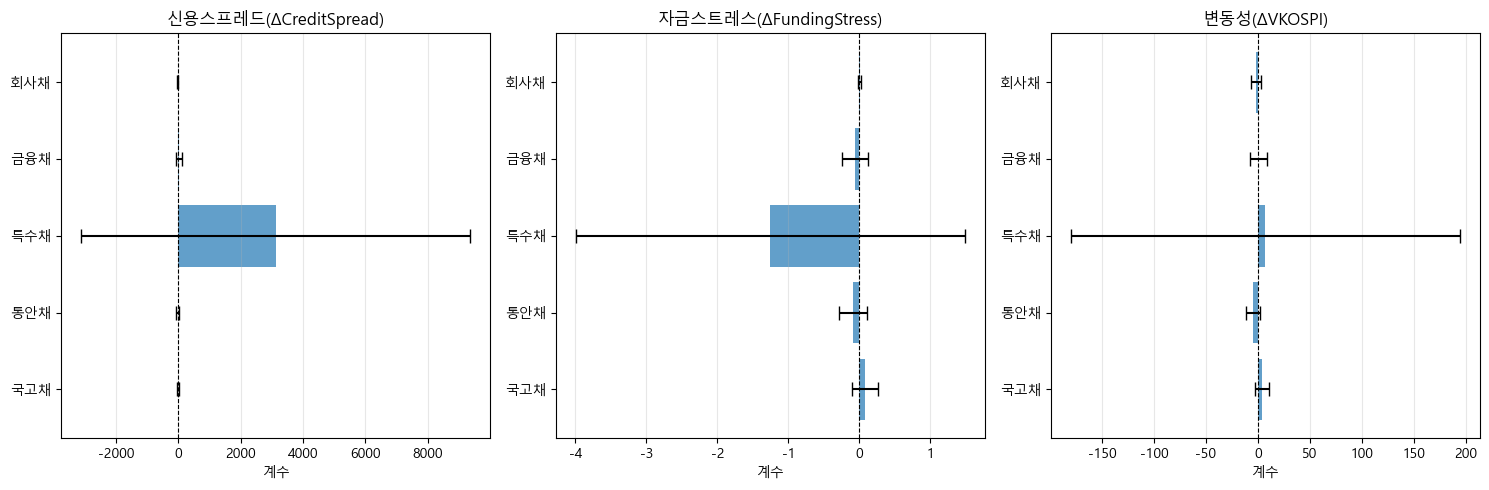

✓ 저장: fig5_regression_coefficients.png


In [ ]:
#%%============================================================================
# [Cell 24] Figure 5: 회귀계수 비교 (담보유형별)
#==============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

variables = ['d_credit', 'd_funding', 'd_vkospi']
var_names = ['신용스프레드(ΔCreditSpread)', '자금스트레스(ΔFundingStress)', '변동성(ΔVKOSPI)']

for idx, (var, var_name) in enumerate(zip(variables, var_names)):
    ax = axes[idx]
    
    coefs = []
    errors = []
    labels = []
    
    for coll_type, result in regression_results.items():
        df_res = result['results_df']
        row = df_res[df_res['변수'] == var]
        if len(row) > 0:
            coefs.append(row['계수'].values[0])
            errors.append(row['표준오차'].values[0] * 1.96)  # 95% CI
            labels.append(coll_type)
    
    y_pos = np.arange(len(labels))
    ax.barh(y_pos, coefs, xerr=errors, capsize=5, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel('계수')
    ax.set_title(var_name)
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()